# One Queue or Two

[One Queue or Two — Modeling and Simulation in Python](https://allendowney.github.io/ModSimPy/queue.html)

In [1]:
from modsim import System, flip, TimeSeries, linrange, decorate, linspace, SweepSeries


def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=10 * 60)


interarrival_time = 8
service_time = 5

lam = 1 / interarrival_time
mu = 1 / service_time

system = make_system(lam, mu)


def update_func1(x, t, system):
    if x > 0:
        if flip(system.mu):
            x -= 1
    if flip(system.lam):
        x += 1
    return x

x = 1
t=0
update_func1(x,t,system)


0

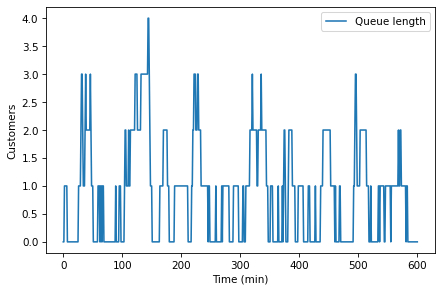

In [2]:
def run_simulation(system, update_func):
    """Simulate a queueing system.

    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries(name='Queue length')
    results[0] = x

    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results


results = run_simulation(system, update_func1)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')

In [3]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.

    results: TimeSeries of queue lengths
    system: System object

    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

compute_metrics(results, system)

(np.float64(0.872093023255814), np.float64(6.976744186046512))

In [4]:
num_vals = 101
lam_array = linspace(0.1*mu, 0.8*mu, num_vals)
lam_array

array([0.02  , 0.0214, 0.0228, 0.0242, 0.0256, 0.027 , 0.0284, 0.0298,
       0.0312, 0.0326, 0.034 , 0.0354, 0.0368, 0.0382, 0.0396, 0.041 ,
       0.0424, 0.0438, 0.0452, 0.0466, 0.048 , 0.0494, 0.0508, 0.0522,
       0.0536, 0.055 , 0.0564, 0.0578, 0.0592, 0.0606, 0.062 , 0.0634,
       0.0648, 0.0662, 0.0676, 0.069 , 0.0704, 0.0718, 0.0732, 0.0746,
       0.076 , 0.0774, 0.0788, 0.0802, 0.0816, 0.083 , 0.0844, 0.0858,
       0.0872, 0.0886, 0.09  , 0.0914, 0.0928, 0.0942, 0.0956, 0.097 ,
       0.0984, 0.0998, 0.1012, 0.1026, 0.104 , 0.1054, 0.1068, 0.1082,
       0.1096, 0.111 , 0.1124, 0.1138, 0.1152, 0.1166, 0.118 , 0.1194,
       0.1208, 0.1222, 0.1236, 0.125 , 0.1264, 0.1278, 0.1292, 0.1306,
       0.132 , 0.1334, 0.1348, 0.1362, 0.1376, 0.139 , 0.1404, 0.1418,
       0.1432, 0.1446, 0.146 , 0.1474, 0.1488, 0.1502, 0.1516, 0.153 ,
       0.1544, 0.1558, 0.1572, 0.1586, 0.16  ])

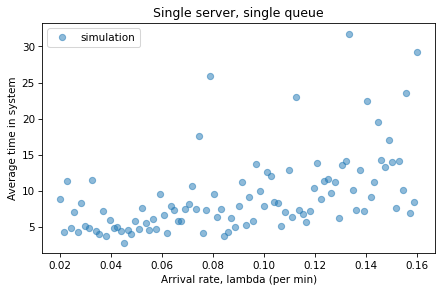

In [5]:
def sweep_lam(lam_array, mu, update_func):
    """Run simulations with a range of values for `lam`

    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    update_func: passed along to run_simulation

    returns: SweepSeries of average wait time vs lam
    """
    sweep = SweepSeries()

    for lam in lam_array:
        system = make_system(lam, mu)
        results = run_simulation(system, update_func)
        L, W = compute_metrics(results, system)
        sweep[lam] = W

    return sweep

sweep = sweep_lam(lam_array, mu, update_func1)
sweep.plot(style='o', alpha=0.5, label='simulation')

decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

Average of averages =  6.103005109956984 minutes


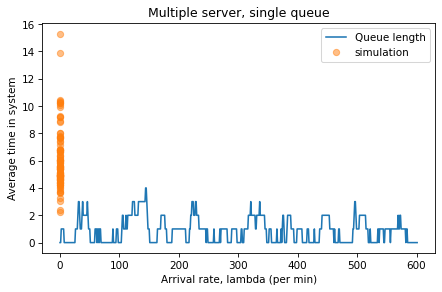

In [6]:
def update_func2(x, t, system):
    """Simulate a single queue with two servers.

    system: System object
    """
    # if both servers are busy, check whether the
    # second is complete
    if x > 1 and flip(system.mu):
        x -= 1

    # check whether the first is complete
    if x > 0 and flip(system.mu):
        x -= 1

    # check for an arrival
    if flip(system.lam):
        x += 1

    return x

# Solution

system = make_system(lam, mu)
run_simulation(system, update_func2)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

# Solution

lam_array = linspace(0.1*mu, 1.6*mu, num_vals)

# Solution

sweep = sweep_lam(lam_array, mu, update_func2)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

# Solution

sweep.plot(style='o', alpha=0.5, label='simulation')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, single queue')

Average of averages =  6.340477483843715 minutes


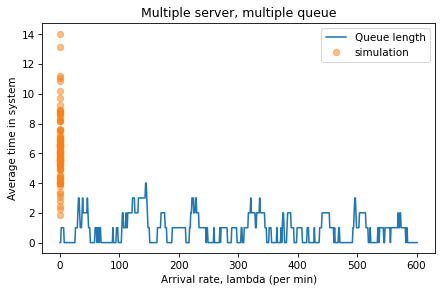

In [7]:
# Solution

def update_func3(x1, x2, t, system):
    """Simulate two queues with one server each.

    x1: number of customers in queue 1
    x2: number of customers in queue 2
    t: time step
    system: System object
    """
    # if the first servers is busy, check it it's done
    if x1 > 0 and flip(system.mu):
        x1 -= 1

    # if the second queue is busy, check if it's done
    if x2 > 0 and flip(system.mu):
        x2 -= 1

    # check for an arrival
    if flip(system.lam):
        # join whichever queue is shorter
        if x1 < x2:
            x1 += 1
        else:
            x2 += 1

    return x1, x2


# Solution

def run_simulation(system, update_func):
    """Simulate a queueing system.

    system: System object
    update_func: function object
    """
    x1, x2 = 0, 0
    results = TimeSeries()
    results[0] = x1 + x2

    for t in linrange(0, system.duration):
        x1, x2 = update_func(x1, x2, t, system)
        results[t+1] = x1 + x2

    return results


# Solution

system = make_system(lam, mu)
run_simulation(system, update_func3)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

# Solution

sweep = sweep_lam(lam_array, mu, update_func3)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

# Solution

sweep.plot(style='o', alpha=0.5, label='simulation')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, multiple queue')